In [1]:

import numpy as np
import matplotlib.pyplot as plt
# import cvxpy as cp 
from scipy import optimize
from scipy.linalg import toeplitz
from numpy import fft 
from core.core import *
from util.detector import * 
from util.estimator import * 
from util.modem import * 

import random
import os 


Bad key text.latex.unicode in file /Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You pr

### The Maximum Likelihood detection

In [2]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

### Near maximum Likelihood detection (Optimization method) 


In [30]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init

def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    # print("inner product term:", inner)
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    # print("numerator", nom)
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    denom = np.clip(a=denom, a_min=0.001, a_max=None)
    # print("denominator: ", denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.transpose(0, 2, 1) @ grad 
    return grad

def GD(x_init, snr, epoch=100, lr=0.01):
    global G_tilde 
    global K
    costs = []
    for e in range(epoch):
        # print(x_init[0].squeeze(), '-->', end=' ')
        x_init += lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        # print(x_init[0].squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init, axis=1).reshape(-1, 1, 1)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 1 == 0 : 
        #     print(f"epoch {e}: cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init


def nML():
    pass 

In [34]:

trials = 1
K = 2; N = 16; T = int(1e4); M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 2)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)
for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in [5]:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        G_tilde = H_re * y_re 

        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

        x_init = initialize(G_tilde=G_tilde, y_re=y_re)
        x_init_c = x_init[:, :K, :] + 1j * x_init[:, K:, :]
        

        _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=20, lr=0.02)
        x_tilde = x_tilde_re[:, :K, :] + 1j * x_tilde_re[:, K:, :]
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
        

        ser = np.sum(1 - np.isclose(x_det_first_stage, x)) / (T * K)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)

        sers.append([ser, ser_ml])
    sers = np.array(sers)
    print("SER per snr:  \n   ", sers[:, 0].squeeze())
    sers_avg += sers     

sers_avg /= trials

Trial #0:  

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


SER per snr:  
    0.0012


In [61]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init

def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    # print("inner product term:", inner)
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    # print("numerator", nom)
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    denom = np.clip(a=denom, a_min=0.001, a_max=None)
    # print("denominator: ", denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.transpose(0, 2, 1) @ grad 
    return grad

def GD(x_init, snr, G_tilde, epoch=100, lr=0.01):
    global K
    costs = []
    for e in range(epoch):
        # print(x_init[0].squeeze(), '-->', end=' ')
        x_init += lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        # print(x_init[0].squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init, axis=1).reshape(-1, 1, 1)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 1 == 0 : 
        #     print(f"epoch {e}: cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init


def nML(H_re, y_re):
    """
    near maximum likelihood method (first stage)
    """
    global snr
    G_tilde = H_re * y_re 
    x_init = initialize(G_tilde=G_tilde, y_re=y_re)
    _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=20, lr=0.02, G_tilde=G_tilde)
    x_tilde = x_tilde_re[:, :K, :] + 1j * x_tilde_re[:, K:, :]
    return x_tilde 

trials = 10
K = 2; N = 16; T = 10000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 2)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)



for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        # near ML estimation(functional)
        x_tilde = nML(H_re, y_re)
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)

        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)


        ser = np.sum(1 - np.isclose(x_det_first_stage, x)) / (T * K)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)

        sers.append([ser, ser_ml])

    sers = np.array(sers)
    print("SER per snr:  \n   ", sers[:, 0].squeeze())
    sers_avg += sers     

sers_avg /= trials

Trial #0:  

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


SER per snr:  
    [3.1980e-01 1.1435e-01 1.5100e-02 1.4500e-03 2.0000e-04 5.0000e-05
 1.0000e-04 1.5000e-04 4.0000e-04]
Trial #1:  SER per snr:  
    [3.196e-01 1.086e-01 1.700e-02 1.450e-03 1.500e-04 1.000e-04 0.000e+00
 1.000e-04 2.500e-04]
Trial #2:  SER per snr:  
    [3.1385e-01 1.1460e-01 1.7750e-02 1.5000e-03 5.0000e-05 5.0000e-05
 0.0000e+00 1.5000e-04 2.5000e-04]
Trial #3:  SER per snr:  
    [3.1890e-01 1.1385e-01 1.6300e-02 1.0000e-03 2.5000e-04 5.0000e-05
 1.0000e-04 0.0000e+00 3.5000e-04]
Trial #4:  SER per snr:  
    [3.1435e-01 1.1450e-01 1.6300e-02 1.2000e-03 2.0000e-04 5.0000e-05
 5.0000e-05 5.0000e-05 5.0000e-04]
Trial #5:  SER per snr:  
    [3.1515e-01 1.1155e-01 1.6350e-02 1.2000e-03 2.0000e-04 1.5000e-04
 1.0000e-04 2.0000e-04 2.0000e-04]
Trial #6:  SER per snr:  
    [3.212e-01 1.139e-01 1.765e-02 1.000e-03 0.000e+00 1.000e-04 5.000e-05
 1.500e-04 2.500e-04]
Trial #7:  SER per snr:  
    [3.1640e-01 1.1445e-01 1.7700e-02 1.3500e-03 5.0000e-05 0.0000e+00
 1.5000e

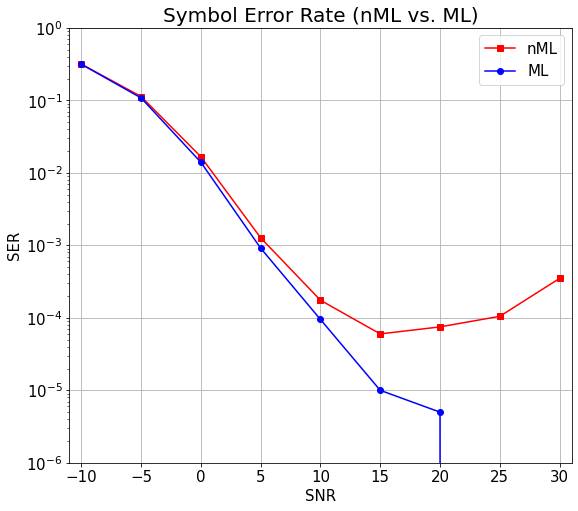

In [62]:
plt.figure(figsize=(9, 8))
plt.semilogy(snr_lst, sers_avg[:, 0], '-rs', label='nML')
# plt.semilogy(snr_lst, sers[:, 1])
plt.semilogy(snr_lst, sers_avg[:, 1], '-bo', label='ML')
plt.xlim([-11, 31]); plt.ylim([1e-6, 1])
plt.xticks(fontsize=15); plt.xlabel("SNR", fontsize=15)
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], fontsize=15); plt.ylabel("SER", fontsize=15)
plt.grid(); plt.legend(fontsize=15); plt.title("Symbol Error Rate (nML vs. ML)", fontsize=20)
plt.show()

[3.1611295e-01 1.0877510e-01 1.3768750e-02 8.8650000e-04 7.5050000e-05
 1.4250000e-05 4.6000000e-06 2.9500000e-06]


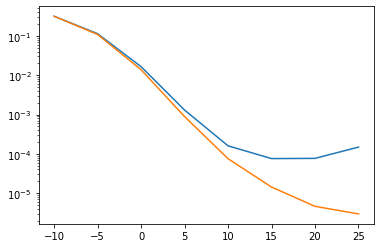

In [38]:
sers_avg_nML = sers_avg[:-1, 0]
save_dir = './results/'
load_fname = "sers_avg_ml.npy"

# plt.semilogy(snr_lst[:-1], sers_avg_nML)
# sers_avg_ml = np.load(save_dir+load_fname)
# print(sers_avg_ml)
# plt.semilogy(snr_lst[:-1], sers_avg_ml)

# plt.show()

## Save simulated nML results

In [40]:
np.save(save_dir + "sers_avg_nML.npy", sers_avg_nML) 

del sers_avg_nML

### load saved results zf to nML (one-stage)

In [6]:
# def loadf(fname: str, load_dir='./results/'):
#     if load_dir == None:    
#         load_dir = "./results/"
#     fname = fname
#     fdir = os.path.join(load_dir, fname)
#     print(fdir)
#     return np.load(fdir)
    
# def get_all_results(load_dir='./results/'):
#     fnames = None 
#     for dir_path, dir_names, fname in os.walk(load_dir):
#         fnames = fname
#     return fnames 

# def load_all_results(load_dir='./results/'):
#     """
#     loads all results and returns its name and value 
#     """
#     results_key = get_all_results()
#     results_value = [loadf(i) for i in results_key]
#     return results_key, results_value
# fnames_lst = None 
# for dir_path, dir_names, fnames in os.walk(save_dir):
#     fnames_lst = fnames
#     print(fnames)

# results = [loadf(i) for i in fnames_lst]

_, results = load_all_results()


results from directory: 
	 ./results/sers_avg_1_bit_zero_forcing.npy
	 ./results/sers_avg_conventional_zero_forcing.npy
	 ./results/sers_avg_bmmse.npy
	 ./results/sers_avg_nML.npy
	 ./results/sers_avg_ml.npy


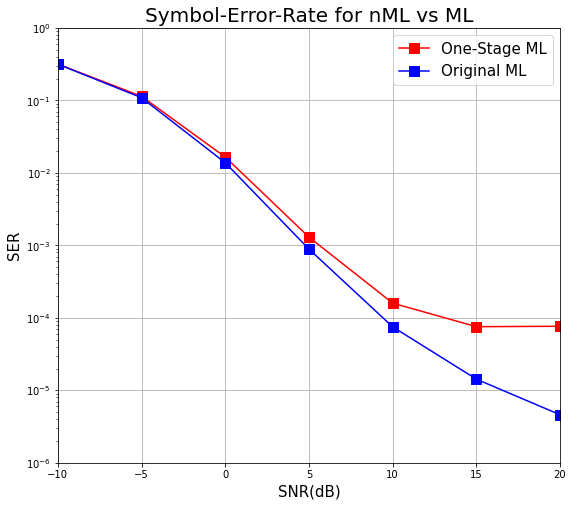

In [7]:
plt.figure(figsize=(9, 8))
# plt.semilogy(snr_lst[1:], results[2], '-s', )
plt.semilogy(snr_lst[:-1], results[3], '-rs', markersize=10, label='One-Stage ML')
plt.semilogy(snr_lst[:-1], results[4], '-bs', markersize=10, label='Original ML')
plt.xlim([-10, 20]); plt.ylim([1e-6, 1e0])
plt.xlabel("SNR(dB)", fontsize=15); plt.ylabel("SER", fontsize=15); plt.title("Symbol-Error-Rate for nML vs ML", fontsize=20)
plt.grid(); plt.legend(fontsize=15)
plt.show()